In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from pyod.models.iforest import IForest
from pyod.models.dif import DIF 
from pyod.models.loda import LODA 
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

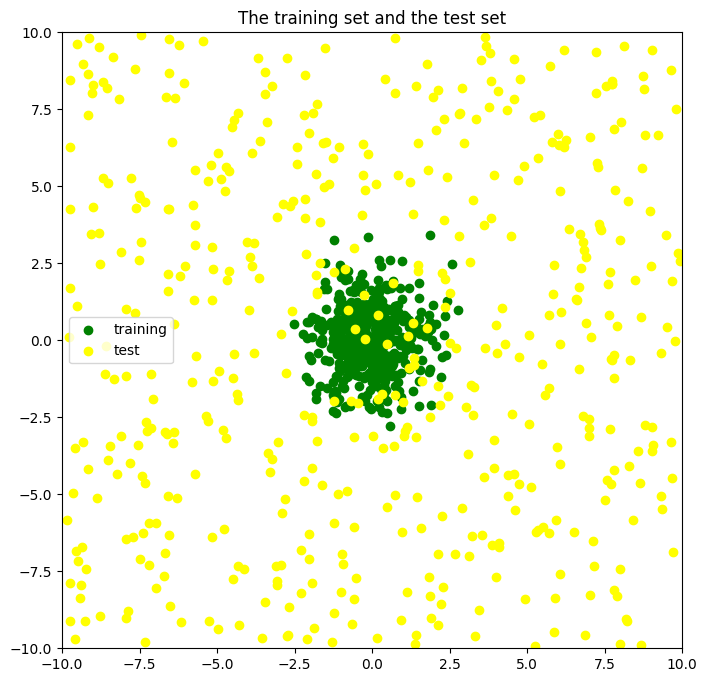

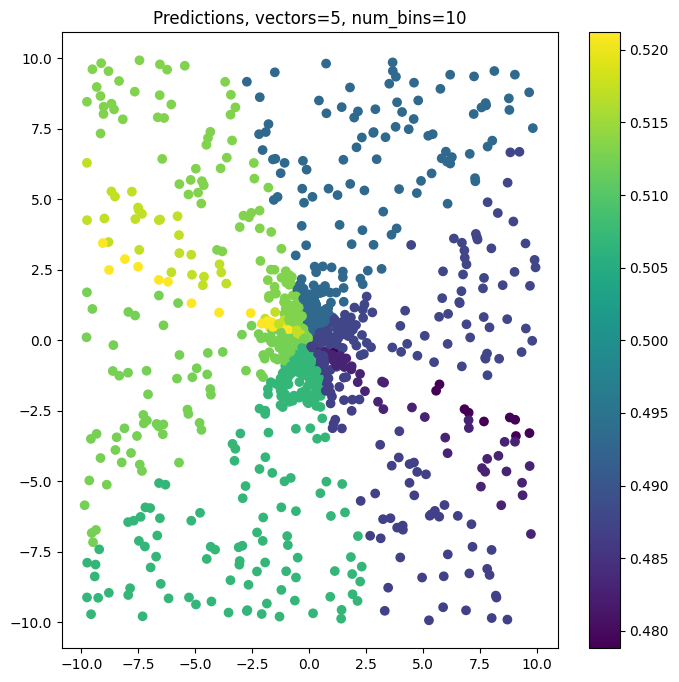

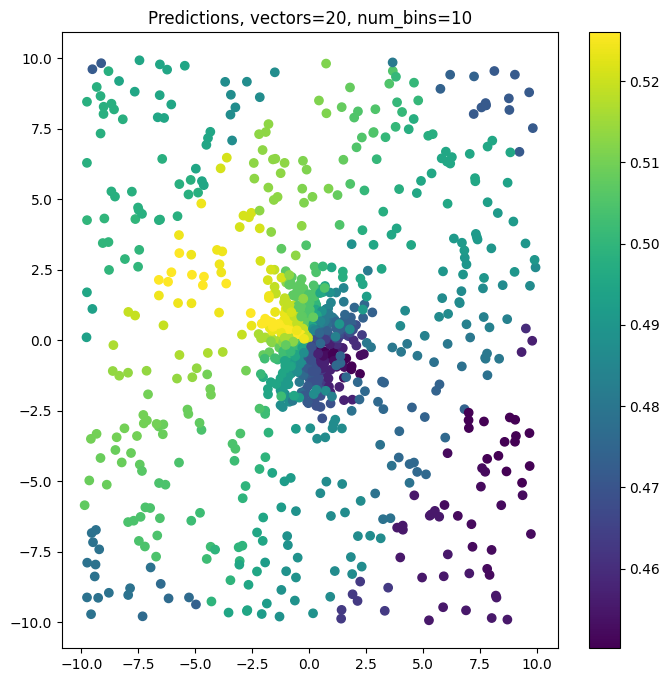

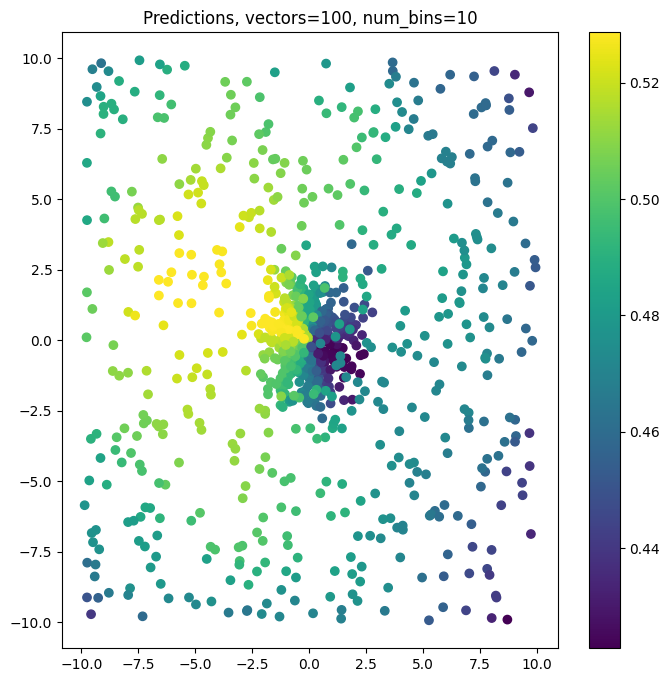

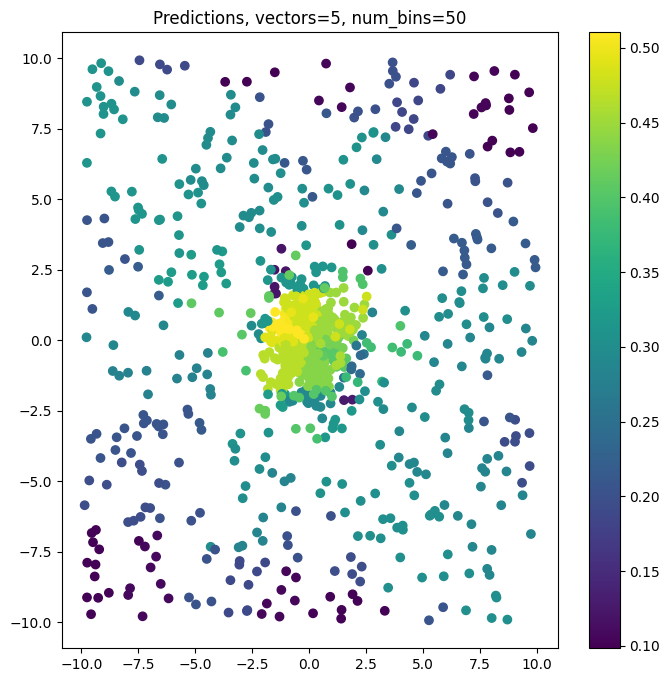

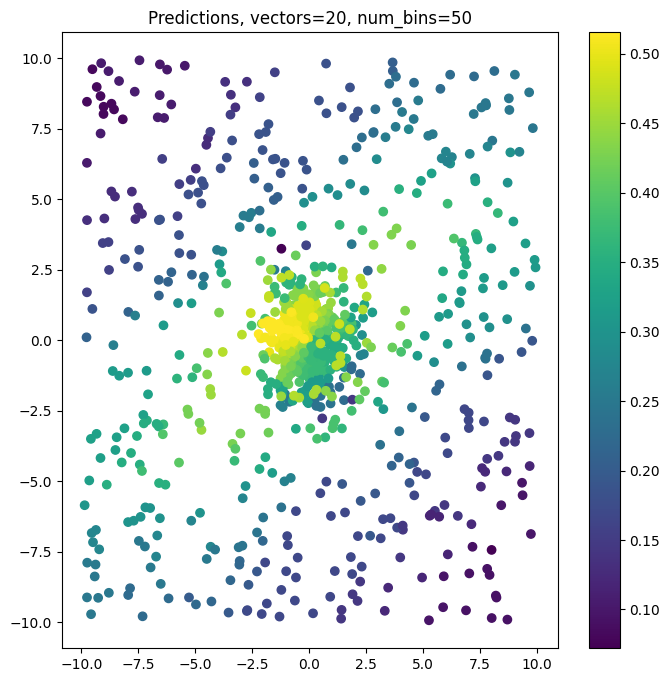

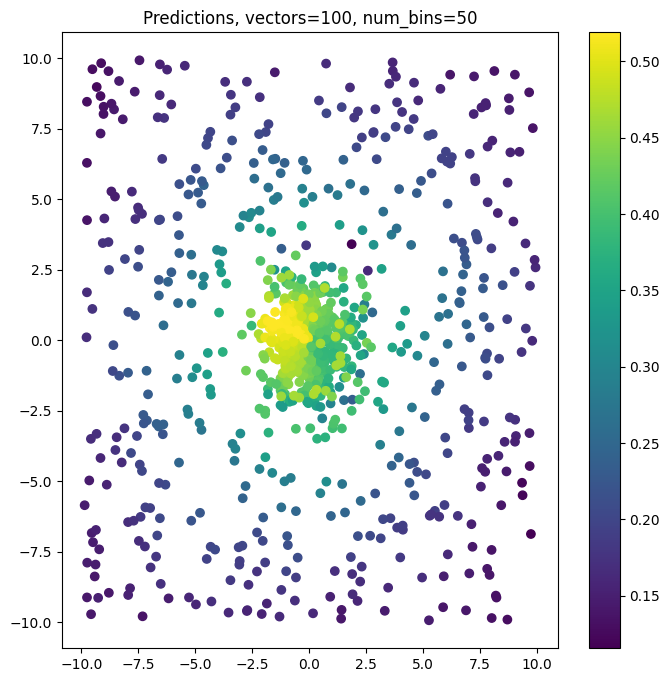

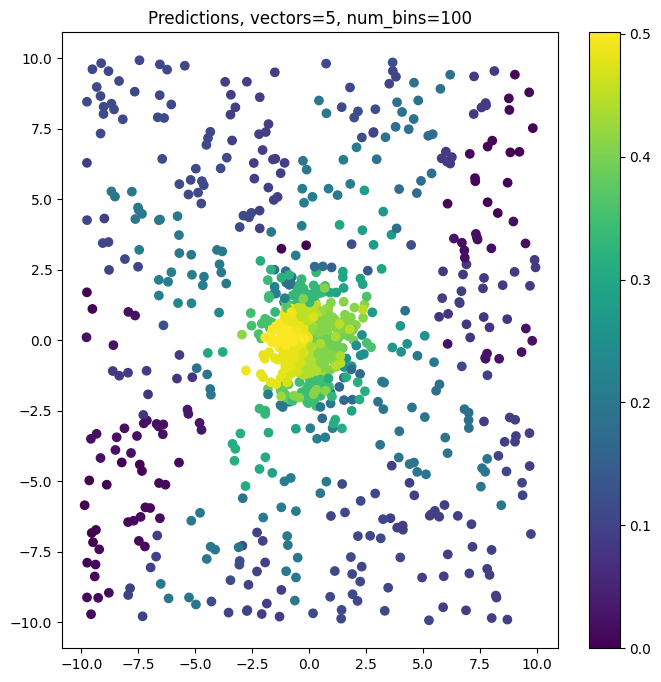

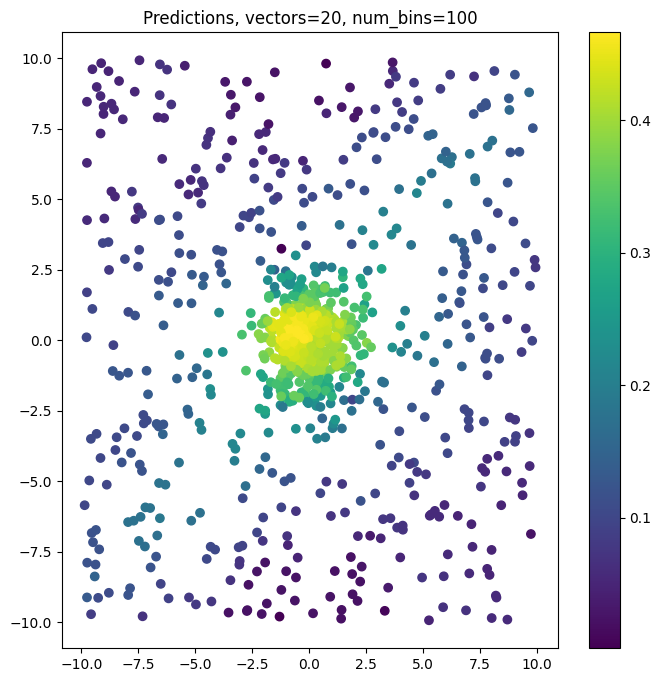

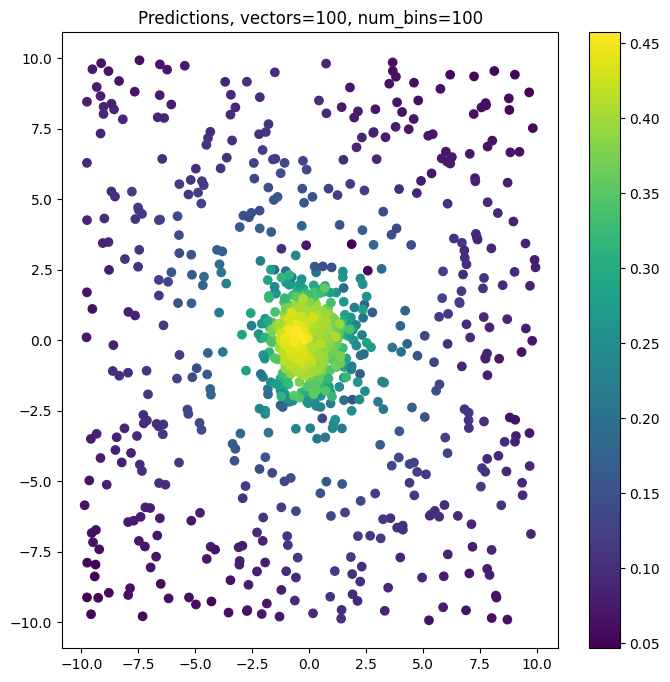

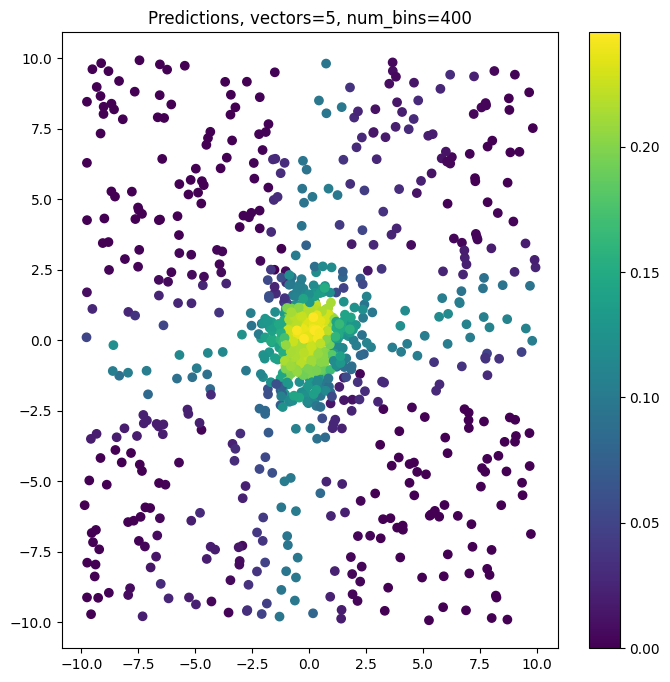

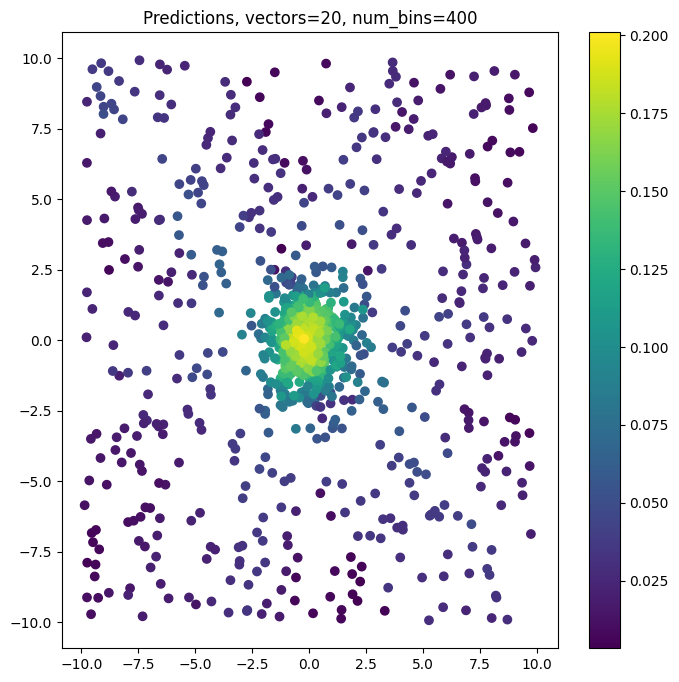

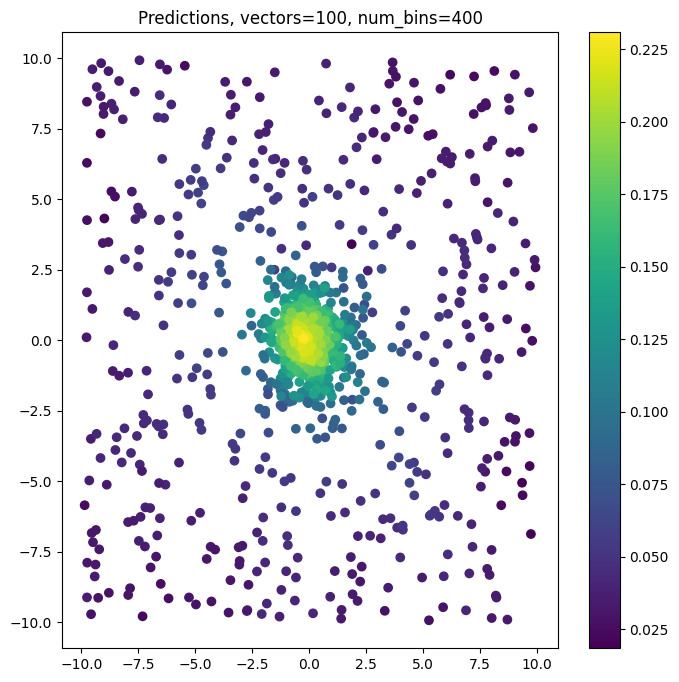

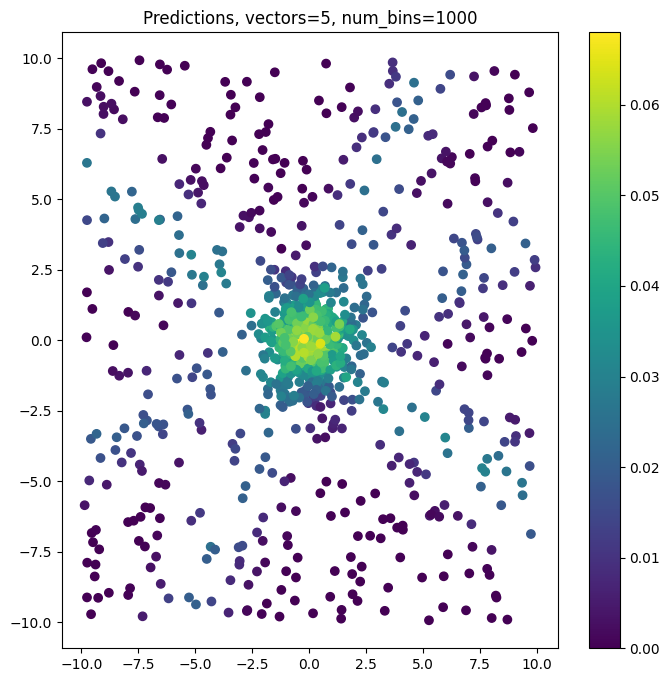

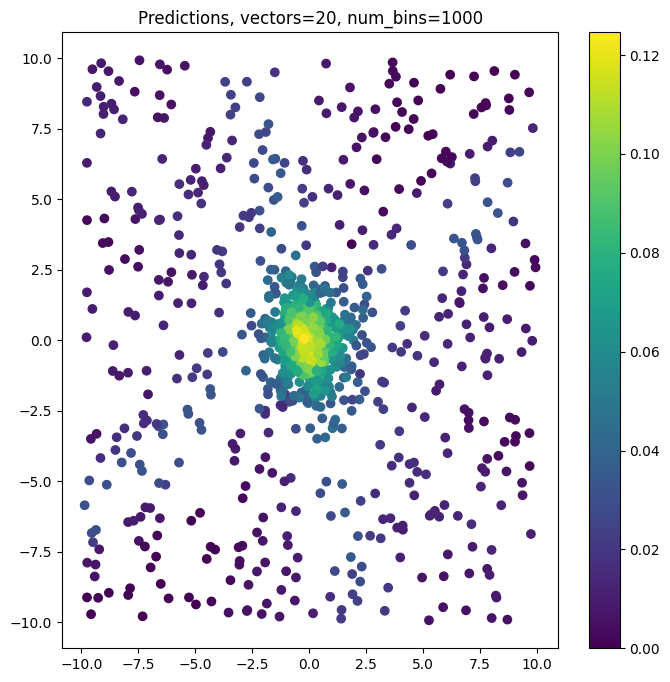

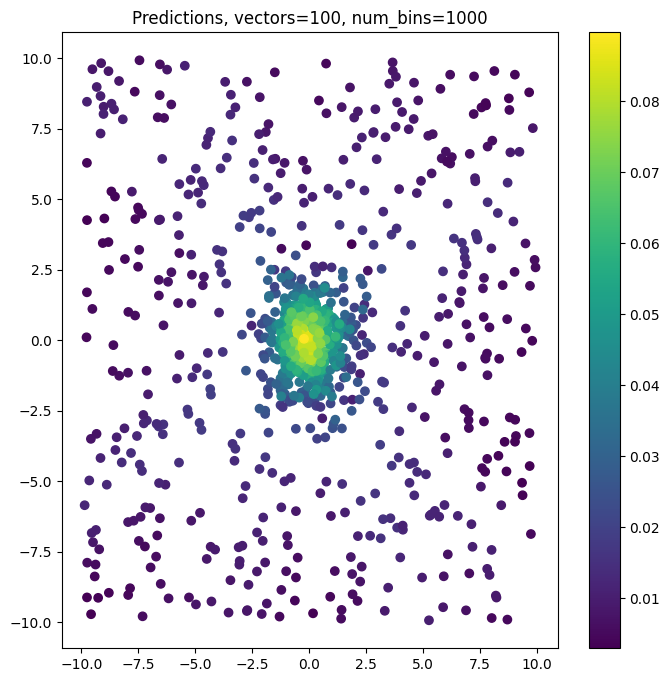

In [88]:
# Exercise 1.

# Returns the projection vectors and the histograms.
def compute_histograms(X, num_projection_vectors=5, num_bins=300):
    # Choosing the 5 projection vectors.
    projection_vectors = np.random.multivariate_normal(mean=(0,0), cov=np.array([[1,0],[0, 1]]), size=num_projection_vectors)

    # Computing the projections.
    projections = X @ projection_vectors.T

    # Generating the histograms.
    histograms = []

    # Generating the histograms.
    for index in range(num_projection_vectors):
        projections_for_vector = projections[:, index]
        histogram, bins = np.histogram(projections_for_vector, bins=num_bins, range=(-100, 100))

        # Normalize the histogram.
        histogram = histogram / len(X)
        
        histograms.append((histogram, bins))

    return (projection_vectors, histograms)


# Get the probability of a sample being an inlier.
def probability(x, simple_loda):
    projection_vectors, histograms = simple_loda

    total_probability = 0 
    
    for i, vector in enumerate(projection_vectors):
        projection = x @ vector.T

        histogram, bins = histograms[i]

        bin = np.digitize(projection, bins)
        
        if bin == 0 or bin == len(bins):
            continue
        
        total_probability += histogram[bin-1]

    total_probability /= len(histograms)

    return total_probability
     
# Generating the dataset.
X_train, _ = make_blobs(n_samples=500, n_features=2, centers=[(0, 0)])
X_test = np.random.uniform([-10, -10], [10, 10], size=(500, 2))

plt.title("The training set and the test set")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.scatter(X_train[:, 0], X_train[:, 1], c="green", label="training")
plt.scatter(X_test[:, 0], X_test[:, 1], c="yellow", label="test")
plt.legend()
plt.show()


parameters = [
    (5, 10),
    (20, 10),
    (100, 10),
    (5, 50),
    (20, 50),
    (100, 50),
    (5, 100),
    (20, 100),
    (100, 100),
    (5, 400),
    (20, 400),
    (100, 400),
    (5, 1000),
    (20, 1000),
    (100, 1000),
]

for num_projection_vectors, num_bins in parameters:
    simple_loda = compute_histograms(X_train, num_projection_vectors, num_bins)

    # Generating the predictions.
    probabilities_train = np.array([probability(x, simple_loda) for x in X_train])
    probabilities_test= np.array([probability(x, simple_loda) for x in X_test])

    plt.title(f"Predictions, vectors={num_projection_vectors}, num_bins={num_bins}")
    plt.scatter(X_train[:, 0], X_train[:, 1], c=probabilities_train)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=probabilities_test)
    plt.colorbar()
    plt.show()

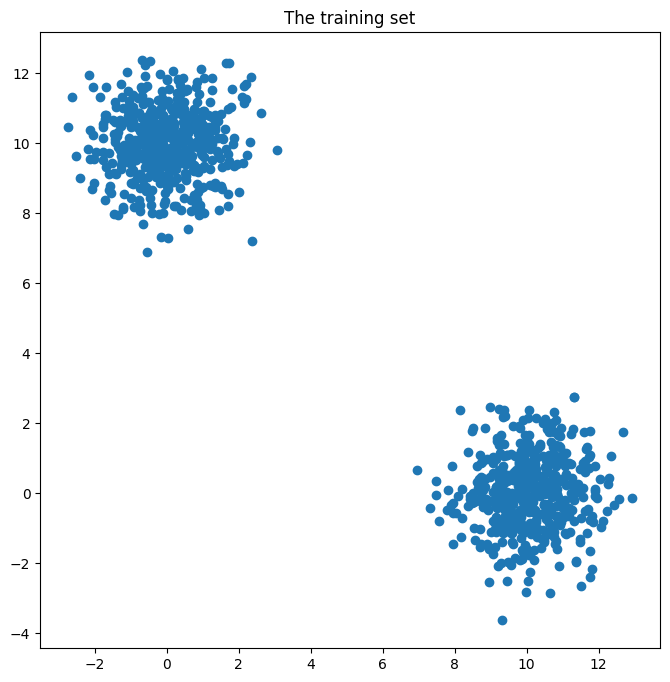

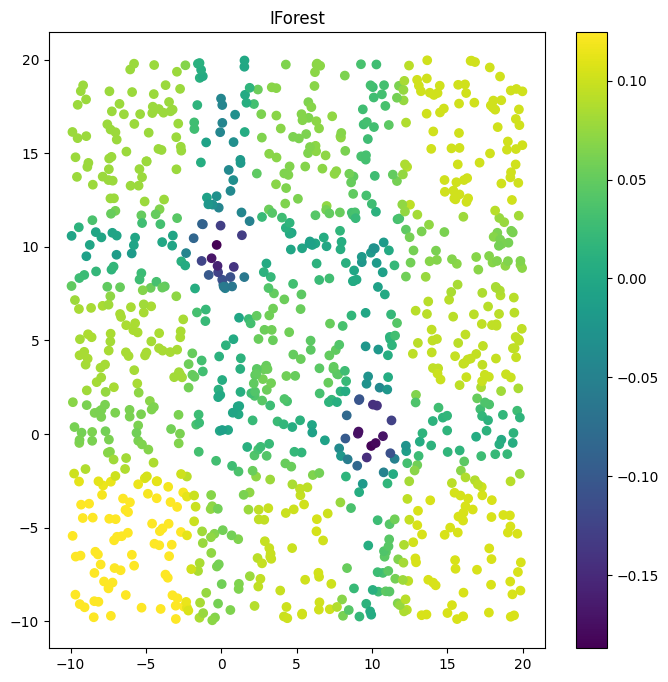

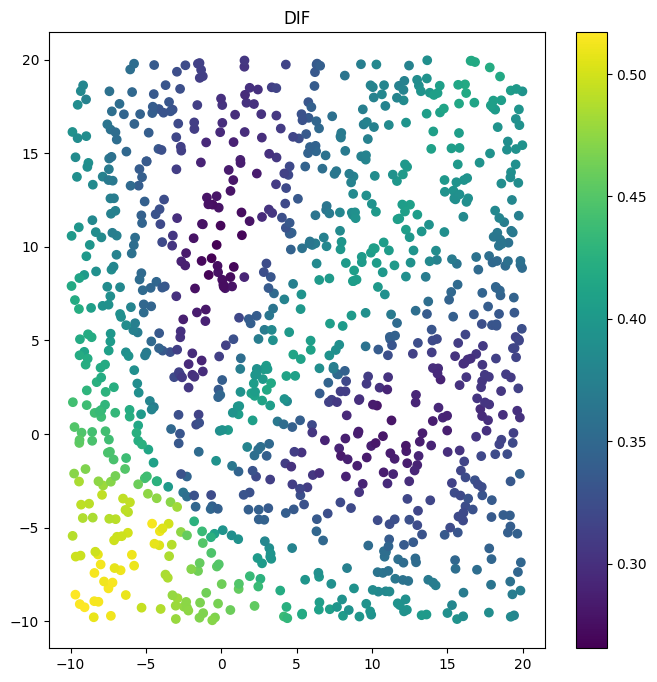

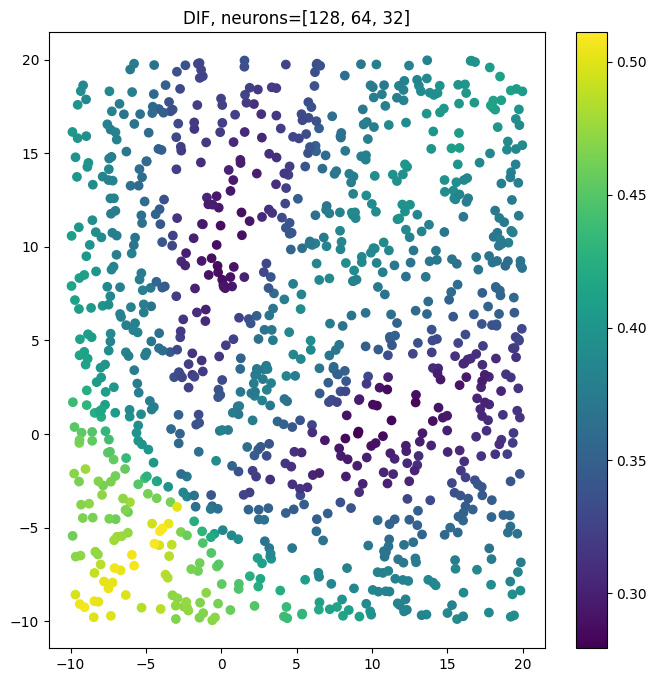

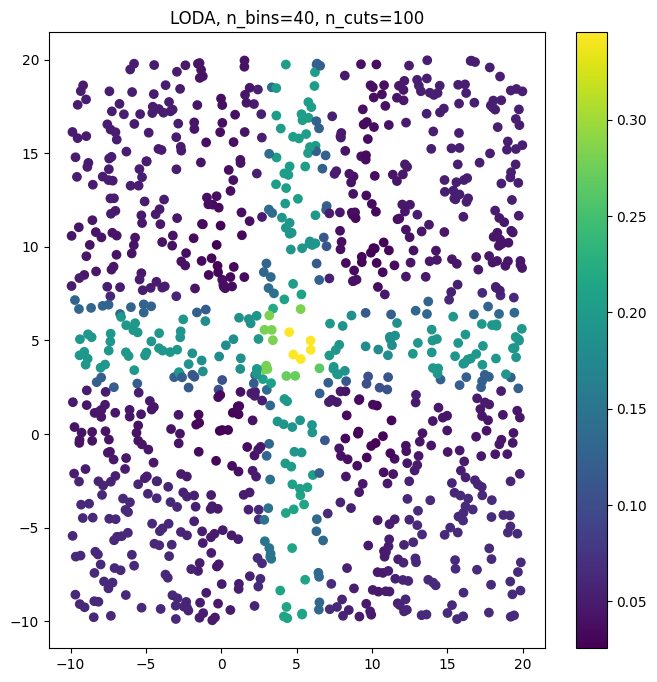

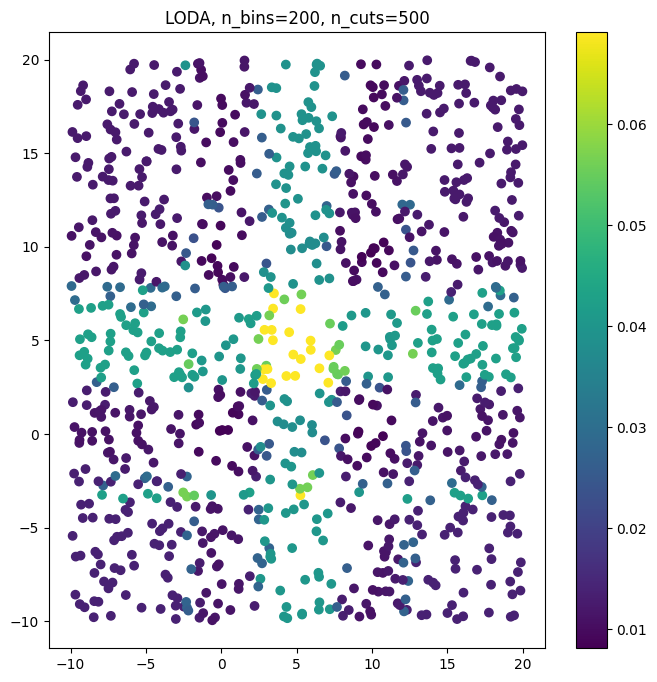

In [89]:
# Exercise 2 - 2D

plt.rcParams["figure.figsize"] = (8,8)

# Generating the data.
X_train, y_train = make_blobs(n_samples=[500,500], n_features=2, centers=[(10, 0), (0, 10)], cluster_std=[1, 1])
X_test = np.random.uniform([-10, -10], [20, 20], size=(1000, 2)) 
    
plt.title("The training set")
plt.scatter(X_train[:, 0], X_train[:, 1])
plt.show()

# Fitting models.
contamination_rate = 0.02
models = [(IForest(contamination=contamination_rate), "IForest"),
          (DIF(contamination=contamination_rate), "DIF"), 
          (DIF(contamination=contamination_rate, hidden_neurons=[128, 64, 32]), "DIF, neurons=[128, 64, 32]"), 
          (LODA(contamination=contamination_rate, n_bins=40, n_random_cuts=100), "LODA, n_bins=40, n_cuts=100"),
          (LODA(contamination=contamination_rate, n_bins=200, n_random_cuts=500), "LODA, n_bins=200, n_cuts=500"),
]

for (i, (model, name)) in enumerate(models):
    model.fit(X_train)
    scores = model.decision_function(X_test)

    plt.title(name)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=scores)
    plt.colorbar()
    plt.show()

In [2]:
# Exercise 3.

# Loading the data.
dataset = loadmat("shuttle.mat")
X, y = dataset["X"], dataset["y"]

def benchmark_models():
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    # Computing contamination rate on the training set.
    contamination_rate = np.mean(y_train)

    # Normalization.
    scaler = StandardScaler() 
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Fitting + predicting
    models = [(IForest(contamination=contamination_rate), "IForest"),
            (DIF(contamination=contamination_rate, hidden_activation="relu", batch_size=256), "DIF"), 
            (LODA(contamination=contamination_rate, n_bins=200, n_random_cuts=500), "LODA, n_bins=200, n_cuts=500"),
    ]

    balanced_accuracies = [] 
    roc_auc_scores = []

    for model, name in models:
        print(f"Fitting {name}")
        model.fit(X_train)

        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)

        scores_train = model.decision_function(X_train)
        scores_test = model.decision_function(X_test)

        balanced_accuracy_train = balanced_accuracy_score(y_train, predictions_train)
        balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)

        roc_auc_score_train = roc_auc_score(y_train , scores_train)
        roc_auc_score_test = roc_auc_score(y_test, scores_test)

        print("Balanced accuracy score train: ", balanced_accuracy_train)
        print("Balanced accuracy score test: ", balanced_accuracy_test)

        print("Roc auc score train: ", roc_auc_score_train)
        print("Roc auc score test: ", roc_auc_score_test)

        balanced_accuracies.append(balanced_accuracy_test)
        roc_auc_scores.append(roc_auc_score_test)
    
    return np.array(balanced_accuracies), np.array(roc_auc_scores)


balanced_accuracies = [] 
roc_auc_scores = [] 
train_test_splits = 10 

for _ in range(train_test_splits):
    ba, roc = benchmark_models()
    balanced_accuracies.append(ba)
    roc_auc_scores.append(roc)

balanced_accuracies = np.array(balanced_accuracies)
roc_auc_scores = np.array(roc_auc_scores)

print("Models: IForest, DIF, LODA")
print("Balanced accuracies: ", balanced_accuracies.mean(axis=0))
print("Roc auc scores", roc_auc_scores.mean(axis=0))

Fitting IForest
Balanced accuracy score train:  0.9707092578457905
Balanced accuracy score test:  0.9734954406658749
Roc auc score train:  0.9958440648168959
Roc auc score test:  0.9968748362642231
Fitting DIF
Balanced accuracy score train:  0.5119708363566396
Balanced accuracy score test:  0.5087692231615165
Roc auc score train:  0.9669320721839512
Roc auc score test:  0.96824386267928
Fitting LODA, n_bins=200, n_cuts=500
Balanced accuracy score train:  0.8802676680363017
Balanced accuracy score test:  0.8870568050371559
Roc auc score train:  0.9812243018964427
Roc auc score test:  0.9847080085358076
Fitting IForest
Balanced accuracy score train:  0.9828912582734253
Balanced accuracy score test:  0.9823441015033643
Roc auc score train:  0.9981571892507399
Roc auc score test:  0.9972593210247109
Fitting DIF
Balanced accuracy score train:  0.5185395476658854
Balanced accuracy score test:  0.5177487655850294
Roc auc score train:  0.9752505489950892
Roc auc score test:  0.975247468315012
